In [1]:
import warnings

warnings.filterwarnings("ignore")
import os

if "jbook" in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../..")))

In [2]:
import matplotlib.pyplot as plt

from explorify.eda.visualize.visualizer import Visualizer
from genailab.setup import auto_wire_container
from genailab.core.dtypes import DFType
from genailab.infra.utils.file.fileset import FileFormat
from genailab.core.flow import PhaseDef, StageDef
from genailab.flow.dataprep.tqa import TQA_FEATURES
# Wire container and obtain the repository
container = auto_wire_container()
repo = container.io.repo()
viz = Visualizer()


# Introduction: Evaluating Review Quality for Aspect-Based Sentiment Analysis
---
Aspect-Based Sentiment Analysis (ABSA) focuses on identifying and extracting sentiment expressed towards specific aspects (e.g., features, attributes) of a product or service within a review.  The quality of a review for ABSA hinges not just on its overall writing quality, but crucially on its *relevance to the target aspects* and the *clarity of sentiment expression* towards those aspects.  A well-written review that doesn't mention any relevant aspects, or one that expresses sentiment vaguely, is of limited use for ABSA.  Therefore, traditional review quality metrics which often prioritize general writing style and length, may not adequately reflect a review's value for ABSA.  

This exploratory data analysis (EDA) is aimed at addressing two key goals related to review quality in the context of ABSA:

**Goal 1:** Evaluate the adequacy of the existing TQA score as a proxy for review quality in ABSA.  Specifically, we will investigate the correlation between TQA scores and the presence and clarity of aspect mentions within reviews.  We hypothesize that a high TQA score does not necessarily guarantee a review's usefulness for ABSA if it lacks relevant aspect mentions or expresses sentiment unclearly.

**Goal 2:** If the TQA score proves inadequate for ABSA (based on the findings from Goal 1), develop an alternative weighting scheme for review features that better reflects review quality for ABSA. This will involve re-evaluating existing features, engineering new aspect-related and sentiment-clarity features, and experimenting with different weighting/scoring methods.

**Methodology:**

Our approach to this EDA involves a combination of quantitative and qualitative analyses:

1. **Data Preparation and Initial Exploration:**  The dataset of reviews, already cleaned and annotated with TQA scores, will be loaded. We will begin by exploring the distribution of TQA scores.  While the scores are continuous, we will experiment with *binning* them into categories (e.g., high, medium, low) for some parts of the analysis, particularly the manual inspection, to make the qualitative analysis more manageable.  We will also examine basic statistics of the TQA scores (mean, standard deviation, percentiles) to understand the overall distribution, and the distribution of review lengths (number of words or sentences) to see any obvious relationship between length and TQA score are is extant.

2. **Manual Inspection (Crucial):** A stratified random sample of reviews, categorized by *binned* TQA score (high, medium, low), will be manually inspected.  This qualitative analysis will be the cornerstone of our investigation.  For each review, we will:
    * Identify and list all mentioned aspects.
    * Assess the clarity of sentiment expression towards each aspect (e.g., is the sentiment clearly positive, negative, or neutral?  Are there ambiguous or conflicting sentiment expressions?).
    * Document any observations about why some high-TQA reviews are not useful for ABSA (e.g., general comments, lack of specific aspect mentions, vague sentiment).

3. **Quantitative Analysis:**  If aspect mention data is available (e.g., a list of aspects associated with each review), we will calculate the correlation between the *continuous* TQA score and measures of aspect coverage (e.g., number of aspects mentioned, proportion of text devoted to aspects).  We will also explore other potential correlations, such as the relationship between TQA score and review length.

4. **Feature Re-evaluation and Engineering:** Based on the insights from the manual inspection, we will re-evaluate the existing features used to calculate the TQA score and identify which ones are relevant for ABSA.  We will also engineer new features that capture aspect relevance (e.g., number of aspect mentions, clarity of aspect mentions) and sentiment clarity (e.g., sentiment strength, polarity consistency).

5. **Weighting/Scoring:** If the TQA score is deemed inadequate, we will explore different methods to combine the selected and engineered features into a new "ABSA usefulness" score. This may include rule-based systems, machine learning models (e.g., regression, ranking), or a hybrid approach.

6. **Evaluation:** The performance of the original TQA score and the newly developed "ABSA usefulness" score will be critically evaluated.  Manual inspection will again play a crucial role in assessing whether the scores accurately reflect a review's value for ABSA.  If machine learning models are used, appropriate evaluation metrics (e.g., precision, recall, F1-score) will be calculated on a held-out test set.


## Data Preparation and Initial Exploration
---
Once we obtain the dataset from the repository, we'll summarize and profile the dataset, then examine the distribution of the `tqa_score` metric.

In [3]:
asset_id = repo.get_asset_id(phase=PhaseDef.DATAPREP, stage=StageDef.TQA, name="review", )
dataset = repo.get(asset_id=asset_id)

### Dataset Summary
---
This summarizes the contents of the dataset in terms of reviews, apps, and reviewers, as well as temporal range and review length statistics. 

In [4]:
dataset.summary



                            AppVoCAI Dataset Summary                            
                             Data Preparation Phase                             
                          Text Quality Analysis Stage                           
                       Number of Reviews | 4,812
                     Number of Reviewers | 4,811
              Number of Repeat Reviewers | 1 (0.0%)
         Number of Influential Reviewers | 294 (6.1%)
                          Number of Apps | 1,866
                 Average Reviews per App | 2.6
                    Number of Categories | 14
                                Features | 23
                       Min Review Length | 3
                       Max Review Length | 492
                   Average Review Length | 37.39
                        Memory Size (Mb) | 3.11
                    Date of First Review | 2021-01-01 02:20:30+00:00
                     Date of Last Review | 2023-08-30 12:49:02+00:00


This is our second view of the AppVoCAI dataset, following data cleaning and the addition of Text Quality Assessment (TQA) and sentiment analysis features.  Compared to our initial view, the dataset is slightly smaller due to the removal of reviews shorter than three words. We've also added eleven TQA-related features and one sentiment analysis feature, bringing the total number of features to 24.  The remaining dataset characteristics (review volume, reviewer and app diversity, time span, etc.) are largely unchanged.

### Dataset Profile
---
Is the dataset complete? Is duplication or null values an issue. The profile below summarizes the structural aspects of the dataset.

In [5]:
dataset.profile

,Column,DataType,Complete,Null,Completeness,Unique,Duplicate,Uniqueness,Size (Bytes)
0,id,string[python],4812,0,1.0,4812,0,1.000000,322866
1,app_id,string[python],4812,0,1.0,1866,2946,0.387781,320011
2,app_name,string[python],4812,0,1.0,1866,2946,0.387781,384993
3,category_id,category,4812,0,1.0,14,4798,0.002909,6222
4,author,string[python],4812,0,1.0,4811,1,0.999792,370524
5,rating,Int16,4812,0,1.0,5,4807,0.001039,14436
6,content,string[python],4812,0,1.0,4809,3,0.999377,1198458
7,vote_sum,Int64,4812,0,1.0,13,4799,0.002702,43308
8,vote_count,Int64,4812,0,1.0,17,4795,0.003533,43308
9,date,"datetime64[ns, UTC]",4812,0,1.0,4812,0,1.000000,38496


This profile mirrors our initial dataset overview, with the addition of TQA-related features.  All columns exhibit 100% completeness and no null values.  The data types and uniqueness of existing columns remain consistent.  The key change is the addition of TQA features (related to noun/verb/adjective/adverb counts, phrase analysis, lexical density, and dependency depth), which will be the focus of our subsequent analysis.

### TQA Score Distribution
---
#TODO: Create distribution plot that contains a histogram, cumulative distribution function plot, violinplot and qqplot. it should also return descriptive statistics.

<Axes: title={'center': 'Tqa Score'}, xlabel='tqa_score', ylabel='Density'>

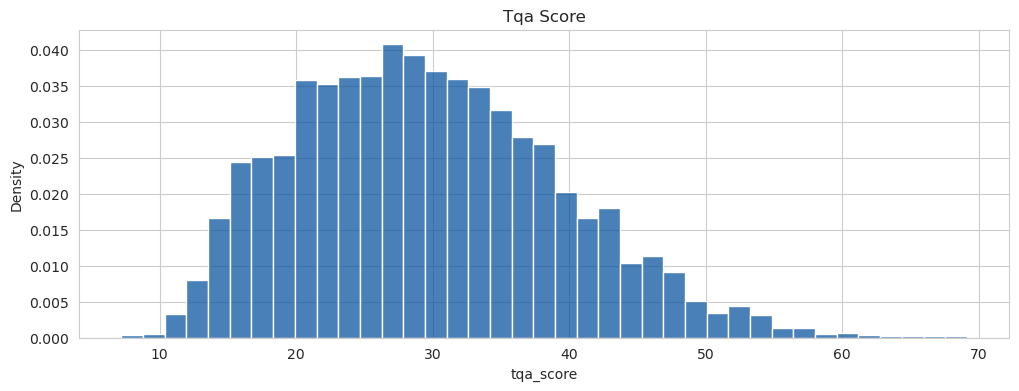

In [6]:
viz.histogram(data=dataset.dataframe, x="tqa_score")

<Axes: title={'center': 'Tqa Score'}, xlabel='tqa_score'>

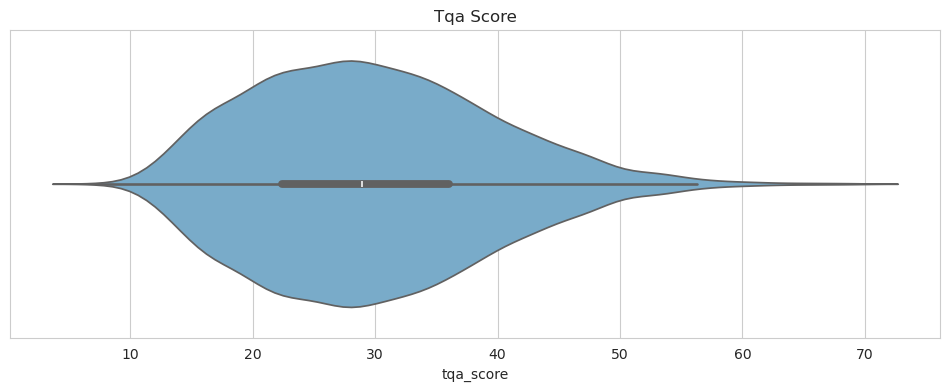

In [7]:
viz.violinplot(data=dataset.dataframe, x="tqa_score")

## Parts of Speech Counts

NameError: name 'tqa' is not defined

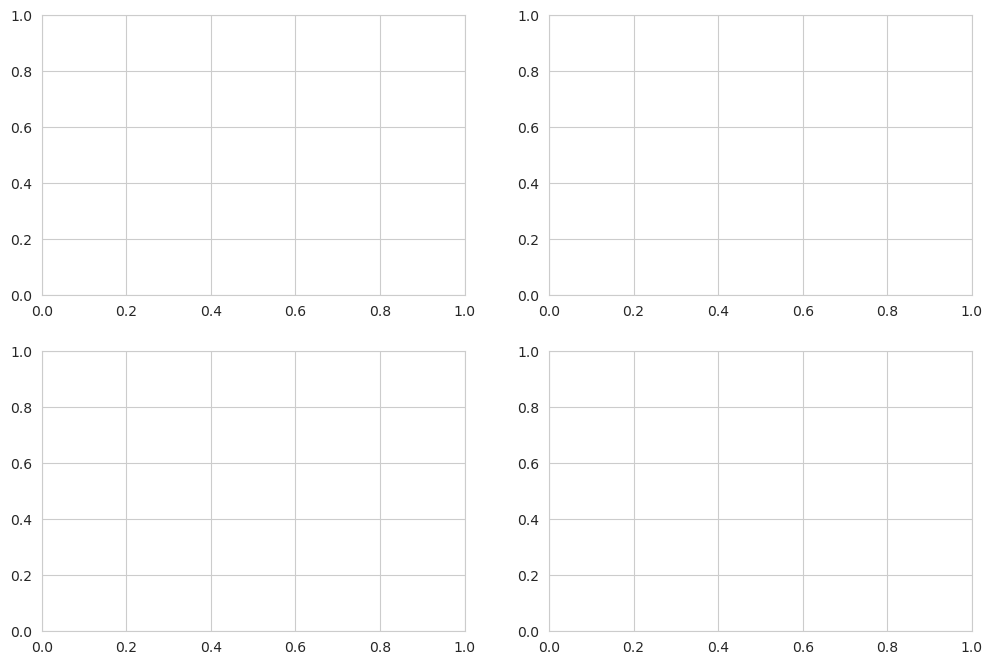

In [8]:
f, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
ax[0,0] = viz.histogram(data=tqa, x="noun_count", ax=ax[0,0], title="Noun Count Distribution")
ax[0,1]= viz.histogram(data=tqa, x="verb_count", ax=ax[0,1], title="Verb Count Distribution")
ax[1,0] = viz.histogram(data=tqa, x="adjective_count", ax=ax[1,0], title="Adjective Count Distribution")
ax[1,1] = viz.histogram(data=tqa, x="adverb_count", ax=ax[1,1], title="Adverb Count Distribution")
f.suptitle(t="Parts of Speech Distributions")
plt.tight_layout()


## Phrase Counts

## Phrase Counts

In [ ]:
f, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
ax[0,0] = viz.histogram(data=tqa, x="aspect_verb_pairs", ax=ax[0,0], title="Aspect Verb Pair Distribution")
ax[0,1]= viz.histogram(data=tqa, x="noun_phrases", ax=ax[0,1], title="Noun Phrases Distribution")
ax[1,0] = viz.histogram(data=tqa, x="verb_phrases", ax=ax[1,0], title="Verb Phrases Distribution")
ax[1,1] = viz.histogram(data=tqa, x="adverbial_phrases", ax=ax[1,1], title="Adverbial Phrases Distribution")
f.suptitle(t="Phrase Distributions")
plt.tight_layout()

## Lexical Features

In [ ]:
f, ax = plt.subplots(nrows=1,ncols=3, figsize=(12,4))
ax[0] = viz.histogram(data=tqa, x="review_length", ax=ax[0], title="Review Length Distribution")
ax[1]= viz.histogram(data=tqa, x="lexical_density", ax=ax[1], title="Lexical Density Distribution")
ax[2] = viz.histogram(data=tqa, x="dependency_depth", ax=ax[2], title="Dependency Depth Distribution")
f.suptitle(t="Lexical Features")
plt.tight_layout()

## Correlation Plot

In [ ]:
tqa = dataset.dataframe[TQA_FEATURES]
viz.corrplot(data=tqa, title="AppVoCAI Text Quality Feature Correlation Plot")

## Parts of Speech and TQA Score

In [ ]:
f, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
ax[0,0] = viz.scatterplot(data=tqa, x="noun_count",y="tqa_score", ax=ax[0,0], title="Noun Counts and TQA Score")
ax[0,1]= viz.histogram(data=tqa, x="verb_count", y="tqa_score",ax=ax[0,1], title="Verb Counts and TQA Score")
ax[1,0] = viz.histogram(data=tqa, x="adjective_count", y="tqa_score",ax=ax[1,0], title="Adjective Counts and TQA Score")
ax[1,1] = viz.histogram(data=tqa, x="adverb_count", y="tqa_score",ax=ax[1,1], title="Adverb Counts and TQA Score")
f.suptitle(t="Parts of Speech and TQA Score")
plt.tight_layout()


## Phrases and TQA Score

In [ ]:
f, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
ax[0,0] = viz.scatterplot(data=tqa, x="aspect_verb_pairs", y="tqa_score", ax=ax[0,0], title="Aspect Verb Pair and TQA Sccore")
ax[0,1]= viz.scatterplot(data=tqa, x="noun_phrases",y="tqa_score", ax=ax[0,1], title="Noun Phrases and TQA Sccore")
ax[1,0] = viz.scatterplot(data=tqa, x="verb_phrases", y="tqa_score",ax=ax[1,0], title="Verb Phrases and TQA Sccore")
ax[1,1] = viz.scatterplot(data=tqa, x="adverbial_phrases",y="tqa_score", ax=ax[1,1], title="Adverbial Phrases and TQA Sccore")
f.suptitle(t="Phrases and TQA Score")
plt.tight_layout()

## Lexical Features and TQA Scores 

In [ ]:
f, ax = plt.subplots(nrows=1,ncols=3, figsize=(12,4))
ax[0] = viz.scatterplot(data=tqa, x="review_length", y="tqa_score", ax=ax[0], title="Review Length and TQA Score")
ax[1]= viz.scatterplot(data=tqa, x="lexical_density",  y="tqa_score",ax=ax[1], title="Lexical Density and TQA Score")
ax[2] = viz.scatterplot(data=tqa, x="dependency_depth", y="tqa_score", ax=ax[2], title="Dependency Depth and TQA Score")
f.suptitle(t="Lexical Features and TQA Score")
plt.tight_layout()